# Imports and Utilities

In [1]:
import copy
import math
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles
from sklearn.model_selection import train_test_split
from termcolor import colored
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation
from matplotlib import colors as mcolors

from IPython.display import HTML


In [3]:
def plot_schedule(schedule_fn, iterations=1500):
    # Iteration count starting at 1
    iterations = [i+1 for i in range(iterations)]
    lrs = [schedule_fn(i) for i in iterations]
    plt.scatter(iterations, lrs)
    plt.xlabel("Iteration")
    plt.ylabel("Learning Rate")
    plt.show()

In [4]:
class TriangularSchedule():
    def __init__(self, min_lr, max_lr, cycle_length, inc_fraction=0.5):
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        inc_fraction: fraction of iterations spent in increasing stage (float)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length
        self.inc_fraction = inc_fraction

    def __call__(self, iteration):
        if iteration <= self.cycle_length*self.inc_fraction:
            unit_cycle = iteration * 1 / (self.cycle_length * self.inc_fraction)
        elif iteration <= self.cycle_length:
            unit_cycle = (self.cycle_length - iteration) * 1 / (self.cycle_length * (1 - self.inc_fraction))
        else:
            unit_cycle = 0
        adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
        return adjusted_cycle

In [5]:
class CosineAnnealingSchedule():
    def __init__(self, min_lr, max_lr, cycle_length):
        """
        min_lr: lower bound for learning rate (float)
        max_lr: upper bound for learning rate (float)
        cycle_length: iterations between start and finish (int)
        """
        self.min_lr = min_lr
        self.max_lr = max_lr
        self.cycle_length = cycle_length

    def __call__(self, iteration):
        if iteration <= self.cycle_length:
            unit_cycle = (1 + math.cos(iteration * math.pi / self.cycle_length)) / 2
            adjusted_cycle = (unit_cycle * (self.max_lr - self.min_lr)) + self.min_lr
            return adjusted_cycle
        else:
            return self.min_lr

In [6]:
class LinearWarmUp():
    def __init__(self, schedule, start_lr, length):
        """
        schedule: a pre-initialized schedule (e.g. TriangularSchedule(min_lr=0.5, max_lr=2, cycle_length=500))
        start_lr: learning rate used at start of the warm-up (float)
        length: number of iterations used for the warm-up (int)
        """
        self.schedule = schedule
        self.start_lr = start_lr
        # calling mx.lr_scheduler.LRScheduler effects state, so calling a copy
        self.finish_lr = copy.copy(schedule)(0)
        self.length = length

    def __call__(self, iteration):
        if iteration <= self.length:
            return iteration * (self.finish_lr - self.start_lr)/(self.length) + self.start_lr
        else:
            return self.schedule(iteration - self.length)

In [7]:
class OneCycleSchedule():
    def __init__(self, start_lr, max_lr, cycle_length, cooldown_length=0, finish_lr=None):
        """
        start_lr: lower bound for learning rate in triangular cycle (float)
        max_lr: upper bound for learning rate in triangular cycle (float)
        cycle_length: iterations between start and finish of triangular cycle: 2x 'stepsize' (int)
        cooldown_length: number of iterations used for the cool-down (int)
        finish_lr: learning rate used at end of the cool-down (float)
        """
        if (cooldown_length > 0) and (finish_lr is None):
            raise ValueError("Must specify finish_lr when using cooldown_length > 0.")
        if (cooldown_length == 0) and (finish_lr is not None):
            raise ValueError("Must specify cooldown_length > 0 when using finish_lr.")

        finish_lr = finish_lr if (cooldown_length > 0) else start_lr
        schedule = TriangularSchedule(min_lr=start_lr, max_lr=max_lr, cycle_length=cycle_length)
        self.schedule = LinearCoolDown(schedule, finish_lr=finish_lr, start_idx=cycle_length, length=cooldown_length)

    def __call__(self, iteration):
        return self.schedule(iteration)

In [8]:
class LinearCoolDown():
    def __init__(self, schedule, finish_lr, start_idx, length):
        """
        schedule: a pre-initialized schedule (e.g. TriangularSchedule(min_lr=0.5, max_lr=2, cycle_length=500))
        finish_lr: learning rate used at end of the cool-down (float)
        start_idx: iteration to start the cool-down (int)
        length: number of iterations used for the cool-down (int)
        """
        self.schedule = schedule
        # calling mx.lr_scheduler.LRScheduler effects state, so calling a copy
        self.start_lr = copy.copy(self.schedule)(start_idx)
        self.finish_lr = finish_lr
        self.start_idx = start_idx
        self.finish_idx = start_idx + length
        self.length = length

    def __call__(self, iteration):
        if iteration <= self.start_idx:
            return self.schedule(iteration)
        elif iteration <= self.finish_idx:
            return (iteration - self.start_idx) * (self.finish_lr - self.start_lr) / (self.length) + self.start_lr
        else:
            return self.finish_lr

In [9]:
class CyclicalSchedule():
    def __init__(self, schedule_class, cycle_length, cycle_length_decay=1, cycle_magnitude_decay=1, **kwargs):
        """
        schedule_class: class of schedule, expected to take `cycle_length` argument
        cycle_length: iterations used for initial cycle (int)
        cycle_length_decay: factor multiplied to cycle_length each cycle (float)
        cycle_magnitude_decay: factor multiplied learning rate magnitudes each cycle (float)
        kwargs: passed to the schedule_class
        """
        self.schedule_class = schedule_class
        self.length = cycle_length
        self.length_decay = cycle_length_decay
        self.magnitude_decay = cycle_magnitude_decay
        self.kwargs = kwargs

    def __call__(self, iteration):
        cycle_idx = 0
        cycle_length = self.length
        idx = self.length
        while idx <= iteration:
            cycle_length = math.ceil(cycle_length * self.length_decay)
            cycle_idx += 1
            idx += cycle_length
        cycle_offset = iteration - idx + cycle_length

        schedule = self.schedule_class(cycle_length=cycle_length, **self.kwargs)
        return schedule(cycle_offset) * self.magnitude_decay**cycle_idx

# Neural Network Architecture - Basic
![](images/nn_output.png)

# Checklist

We know:
1. What a Neural Network Architecture is
2. When input is feeded into the network we get an output(score) from the output layer of the network
3. Loss functions, which tells us how bad our output is as compared to the actual.
4. Backpropogation - Way to **nudge** the weights of neurons by calculating the gradient of the loss function. 
5. Optimizers - Tells how to change the parameters of our model, by how much, and when?

# Optimization vs Optimizers

In a nutshell, optimization is a minimization problem.But the question is what do we need to minimize in our context.

In a Learning problem we have a **Loss-Function** or a **Target function** which is a mathematical way of measuring how wrong our predictions are.During the training process, we tweak and change the parameters (weights) of our model to try and minimize that loss function, and make our predictions as correct as possible.So we need a way that tells us **How do we change the parameters of our model, by how much, and when?** and that way is by using **Optimizers**
<br>
<br>
**Optimizers**<br>
In simpler terms, optimizers shape and mold your model into its most accurate possible form by futzing with the weights. The loss function is the guide to the terrain, telling the optimizer whether it’s moving in the right or wrong direction





# Batch Gradient Descent

Gradient descent update:
        \begin{align}
        w_{t+1}=w_t− \eta \bigtriangledown f(x),
    \end{align}

where $ \eta$ is the Learning Rate


**In simple english**
1. Calculate what a small change in each individual weight would do to the loss function (i.e. which direction we should move in)
2. Adjust each individual weight based on its gradient (i.e. take a small step(determined by learning rate) in the determined direction)
3. Keep doing $ Steps-1$ and $Step-2$ until the loss function gets as low as possible


# Learning Rate

Ensures that we change our weights at the right pace, not making any changes that are too big or too small.

![](https://proxy.duckduckgo.com/iu/?u=https%3A%2F%2Fqph.fs.quoracdn.net%2Fmain-qimg-ed4a3867ca90b95b33b95f1b89d8335c-c&f=1)

# Loss Function Curve in 3 dimension

![](https://proxy.duckduckgo.com/iu/?u=https%3A%2F%2Fcdn-images-1.medium.com%2Fmax%2F1600%2F1*iU1QCnSTKrDjIPjSAENLuQ.png&f=1)

# Critical Points 

When $f'(x) = 0$, the derivative provides no information about which direction to move. Points where $f'(x) = 0$ are known as **critical points** or **stationary points**
<br><br>
**Types of Critical Points:**
1. **Local Minimum**-Point where $f(x)$ is lower than at all neighboring points, so it is no longer possible to decrease $f(x)$ by making infinitesimal steps.<br>
2. **Local Maximum** Point where $f(x)$ is higher than at all neighboring points,so it is not possible to increase $f(x)$ by making infinitesimal steps.
3. **Saddle Points**-Slopes (derivatives) in orthogonal directions are all zero,but these points are neither maxima nor minima.
4. **Global Minimum**-Point that obtains the absolute lowest value of $f(x)$

![](images/Critical_Points.png)

## Saddle Point in 3D

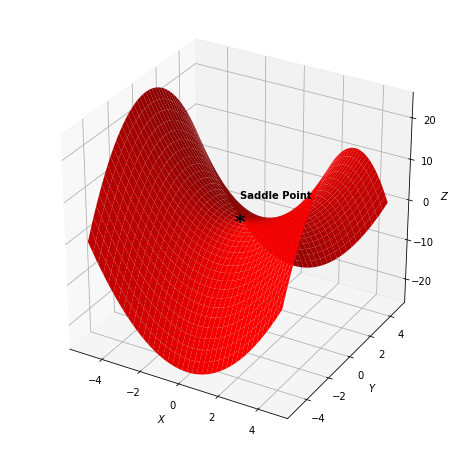

In [10]:
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
X = np.arange(-5, 5, 0.25)
Y = np.arange(-5, 5, 0.25)
X, Y = np.meshgrid(X, Y)
Z = X**2 - Y**2

ax.text2D(0,0,'*',fontdict={'ha': 'center', 'va': 'center', 'family': 'sans-serif','fontweight': 'bold',"fontsize":20})
ax.text2D(0,0.01,'Saddle Point',fontdict={'family': 'sans-serif','fontweight': 'bold'})
ax.set_xlabel('$X$')
ax.set_ylabel('$Y$')
ax.set_zlabel(r'$Z$')
ax.plot_surface(X, Y, Z,color="red");

## Pathological Curvature 3D

![](images/pathological_curvature.png)

## Pathological Curvature 2D
![](images/pathological_curvature1.png)

# Optimizers with Adaptive Learning Rates

Other than SGD there are many more different optimization alogrithms which provide an efficient and faster convergence method to handle the pathelogical curve problems by updating the weights and biases.Some of them are lsited below:
<br>
1. Nestrov Acclerated Gradient
2. Adagrad
3. Adadelta
4. RMSprop
5. Adam
6. AdaMax
7. Nadam
8. AMSGrad

![](https://cdn-images-1.medium.com/max/1600/1*SjtKOauOXFVjWRR7iCtHiA.gif)

# Problem at Hand

1. Need to experimentally find the best learning rate values and schedule for the global learning rates

![](images/lr_vs_epoch.png)
2. Adaptive Leanring rates like AdaGrad,RMSProp,AdaDelta are not computationally simple.
3. Difficulty in minimizing the loss arising from saddle points rather than poor local minima as saddle points have small gradients that slows the learning process.
4. Convex Loss Function is a Myth...

Highly non-convex loss functions for vgg56
![](images/vgg56_curve.jpg)

# Our Objective

![](images/good_local_minima.png)

# Advanced Learning Rate Schedulers

Changing learning rate over Schedules

1. Schedules define how the learning rate changes over time
2. Specified for each epoch or each iteration of training

They are different from adaptive methods because they:
1. Change the global learning rate for the optimizers,rather than parameter-wise learning rates.
2. Don't take feedback from the training process and are specified beforehand.


## Different shapes for Learning Rate Schedules

Approaches:
1. Step Change

![](images/step_change_lr.png)
2. Smooth linear decrease
![](images/linear_lr.png)
3. Cyclical

[Cyclical Learning Rates for Training Neural Networks-2015-2016](https://arxiv.org/pdf/1506.01186.pdf)
![](images/cyclical.png)

4. Cosine Form

[SGDR: STOCHASTIC GRADIENT DESCENT WITH WARM RESTARTS-2017](https://arxiv.org/pdf/1608.03983.pdf)

![](images/cosine_lr.png)

# Cyclical Learning Rate

[Cyclical Learning Rates for Training Neural Networks-2015-2016](https://arxiv.org/pdf/1506.01186.pdf)

**What they are and what they are not**

1. They are a framework to vary learning rate during training and hence helps in letting the global learning rate vary cyclically within a band of values instead of setting it to a fixed value.
2. They are fundamentally different from adaptive learning rate and they can combine with adaptive learning rates.
2. Cyclical Learning Rate is similar to Stocastic Gradient Descent  with Restarts Methods.


**Advantages**
1. No need to tune the learning rate
2. Obtain near Optimal Accuracy for any task
3. Implementing cyclical learning rate make sure rapid traversal of saddle points plateaus due to increasing learning rates.

# Different Functional Form for varying learning Rates

1. Trinagular Window (linear)
2. Welch Window (Parabolic)
3. Hann Window (Sinusoidal)

## Hyperparameters in Cyclical Learning Rate

1. Minimum Learning Rate
2. Maximum Learning Rate
3. Step Size : 2 to 10 times the number of iterations in an epoch
4. Cycle Length - 2 times the step size  

![](images/clr.png)



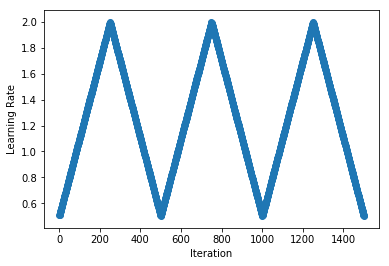

In [11]:
schedule = CyclicalSchedule(TriangularSchedule, min_lr=0.5, max_lr=2, cycle_length=500)
plot_schedule(schedule)

# Learning Rate Range test (LR Finder)

Used to determine if super-convergence is possible for an architecture
<br>
How we do it..

1. Choose a minimum and maximum learning rate
2. Set step size = max_iterations(total epochs) 
    <br>generall epochs ranges between 1 to 5
3. Plot accuracy vs learning rate(lr finder plot) and choose min lr when accuracy starts to increase and max lr when accuracy starts to decrease.

![](images/lr_finder.png)

# LR Modified

## SGD with Warm up

[Accurate, Large Minibatch SGD:
Training ImageNet in 1 Hour - 2017](https://arxiv.org/pdf/1706.02677.pdf)

Mostly focussed on demonstrating feasibility of large scale training with distributed Stochastic Gradient Descent approach

**Salient Points**

1. Trained ImageNet Data on ResNet50 in 1 hour.
2. Trained on 256 GPU with batchsize of 8192 as compared to 8 GPU with batch size of 256 for over 29 hours
3. Provided the same level of accuracy as the 256 minibatch baseline. 
4. Present a new warmup strategy, i.e., a strategy of using lower learning rates at the start of training, to overcome early optimization difficulties
5. Came up with Linear Scaling rule i.e When the minibatch size is multiplied by k, multiply the learning rate by k

![](images/warm_up.png)

However in the initial training when the network is changing rapidly, linear scaling does not hold which can be addressed using **gradual warmup phase**.
<br>
Also  minibatch size cannot be scaled indefinitely: while results are stable for a large range of sizes,beyond a certain point accuracy degrades rapidly.For **Imagenet it was around 8K images**

**Gradual Warmup**
The idea is to start from a learning rate of η and increment it by a constant amount at each iteration such that it reaches ηˆ = kη after 5 epoch

# 1 Cycle Policy

[Super-Convergence: Very Fast Training of Neural Networks Using Large Learning Rates](https://arxiv.org/pdf/1708.07120.pdf)

1. We progressively increase our learning rate from $\frac{lr\_max}{div\_factor}$ to $lr\_max$ and at the same time we progressively decrease our momentum from $mom\_max$ to $mom\_min$.
2. We do the exact opposite : We progressively decrease our learning rate from $lr\_max$ to $\frac{lr\_max}{div\_factor}$ and at the same time we progressively increase our momentum from $mom\_min$ to $mom\_max$.
3. We further decrease our learning rate from  $\frac{lr\_max}{div\_factor}$  to  $\frac{lr\_max}{div\_factor x 100}$ and we keep momentum steady at mom_max.

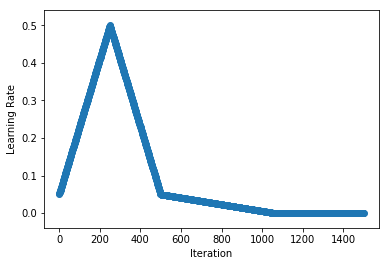

In [12]:
schedule = OneCycleSchedule(start_lr=0.05, max_lr=0.5, cycle_length=500, cooldown_length=550, finish_lr=0.001)
plot_schedule(schedule)

## SGD with Warm Restarts

[SGDR: STOCHASTIC GRADIENT DESCENT WITH WARM RESTARTS](https://arxiv.org/pdf/1608.03983.pdf)

Salient Points

1.  SGD with warm restarts requires 2× to 4× fewer epochs than the currently-used learning rate schedule chemes to achieve comparable or even better results.
2. The restarts are not performed from scratch but emulated by decreasing the learning rate $η_t$ by some factor to the original starting learning rate.
3. As we decrease the learning rate by some factor during restarts, we can increase the cycle length to have a better convergence. 

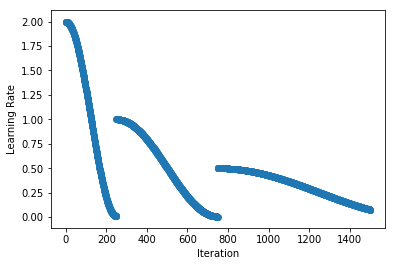

In [13]:
schedule = CyclicalSchedule(CosineAnnealingSchedule, min_lr=0.01, max_lr=2,
                            cycle_length=250, cycle_length_decay=2, cycle_magnitude_decay=0.5)
plot_schedule(schedule)

# Our Results

## Computer Vision Task

We did Benchmarking in 2 computer vision task.


###  1. Transfer Learning using Resnet-50 model.
![](images/resnet_comparison.jpg)

Here the normal training gives 86.34% in 10 epochs and Super Convergence gives 89.80% in 5 epochs. 

### 2. Traning DenseNet-BC 121 Architecture for Cifar10.
![](images/desnet_comparison.jpg)

Here the normal training gives 86% in 8 epochs and Super Convergence gives 90% in 9 epochs.

## NLP Task

We trained OpenAI GPT model for 100 epochs on wikitext and here is the result.

Train Loss: 4.299 Val. Loss: 4.461

# References

1. [Code](https://colab.research.google.com/drive/1Q72MaPlrAp1ZyRhkI3RHDjIDo0ZcGP0a)
2. [Optimizers Visualization](https://gitlab.com/entirety.ai/meetup-intuition-to-implementation/blob/master/Phase%20-%201/Session-1%20and%202/7_Optimizers.ipynb)
1. [Super Convergence paper](https://arxiv.org/abs/1708.07120)
2. [1 Cycle Policy](https://docs.fast.ai/callbacks.one_cycle.html)
3. [LR Scheduler Keras](https://www.pyimagesearch.com/2019/07/22/keras-learning-rate-schedules-and-decay/)
4. [Mxnet](https://mxnet.apache.org/api/python/docs/tutorials/packages/gluon/training/learning_rates/learning_rate_schedules_advanced.html)
5. [Optimizers](https://blog.paperspace.com/intro-to-optimization-momentum-rmsprop-adam/)